<a href="https://colab.research.google.com/github/ReidelVichot/LC_identification/blob/main/annual_Air_012525.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting the Environment

In [70]:
from google.colab import drive
drive.mount('/content/drive')

# -- Setting environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# -- Load county shapefiles
dir = "/content/drive/MyDrive/Disertation/countyshp/"
county = gpd.read_file(dir + "tl_2010_us_county00/tl_2010_us_county00.shp")
county = county[["CNTYIDFP00", "geometry"]]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
dir = "/content/drive/MyDrive/Disertation/EPA_data/Summary/"

# -- Create pollution indicators
ind_temp = pd.DataFrame()
# -- Columns of interest
#cols = ["State", "County", "Year", "Median AQI"]

for year in range(1998, 2023):
  df = pd.read_csv(dir + f"annual_conc_by_monitor_{year}.csv", low_memory = False)
  #df = df[cols]
  ind_temp = pd.concat([ind_temp, df]).reset_index().drop(columns="index")

# -- Generate GEOID
ind_temp["GEOID"] = ind_temp["State Code"].astype(str).str.zfill(2) + ind_temp["County Code"].astype(str).str.zfill(3)
ind_temp["GEOID"] = ind_temp.GEOID.astype(str)
# -- Delete some columns
ind_temp.drop(columns=["State Code", "County Code", "Latitude", "Longitude", "Datum"], inplace=True)
ind_temp.drop(columns=['1st Max Value', '1st Max DateTime',
       '2nd Max Value', '2nd Max DateTime', '3rd Max Value',
       '3rd Max DateTime', '4th Max Value', '4th Max DateTime',
       '1st Max Non Overlapping Value', '1st NO Max DateTime',
       '2nd Max Non Overlapping Value', '2nd NO Max DateTime',
       '99th Percentile', '98th Percentile', '95th Percentile',
       '90th Percentile', '75th Percentile', '50th Percentile',
       '10th Percentile', 'Local Site Name', 'Address', 'State Name',
       'County Name', 'City Name', 'CBSA Name', 'Date of Last Change'], inplace=True)
#ind_temp.drop(columns=['Required Day Count', 'Exceptional Data Count', 'Null Data Count',
#       'Primary Exceedance Count', 'Secondary Exceedance Count',
#      'Certification Indicator', 'Num Obs Below MDL'], inplace=True)

cols = ['GEOID', 'Parameter Name', "Parameter Code", "Site Num", "POC",
       'Sample Duration', 'Pollutant Standard', 'Metric Used',
       'Year', 'Units of Measure', 'Event Type', 'Observation Count',
       'Completeness Indicator', 'Valid Day Count',
       'Arithmetic Mean', 'Arithmetic Standard Dev']
ind_temp = ind_temp[cols]

# Remove cases in which events occurred
ind_temp = ind_temp[(ind_temp["Event Type"]=="No Events")|(ind_temp["Event Type"]=="Events Excluded")]
ind_temp.drop(columns=["Event Type"], inplace=True)
# Data is complete
ind_temp = ind_temp[ind_temp["Completeness Indicator"]=="Y"]
ind_temp = ind_temp.drop(columns=["Completeness Indicator"]).copy()

# Ozone Units of Measure is Parts per million
ozone = ind_temp[ind_temp["Parameter Name"]=="Ozone"]
ozone = ozone[ozone["Units of Measure"]=="Parts per million"]
ozone = ozone[ozone["Metric Used"]=='Daily maximum of 8-hour running average']

ozone = ozone.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
cols = ["GEOID", "Year", "Arithmetic Mean"]
ozone = ozone[cols]

co = ind_temp[ind_temp["Parameter Name"]=="Carbon monoxide"]

co = co[co["Metric Used"]=='Obseved hourly values']
co.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index().head()
co = co[cols]

<ipython-input-91-1568616672fb>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_temp.drop(columns=["Event Type"], inplace=True)


##AQI

In [ ]:
# One file links state names with their abbreviation code, and the other one
# links the county name with the state and county fips
# --- This data was downloaded to the Disertation folder
state_postal = "https://www2.census.gov/geo/docs/reference/state.txt"
name_to_fips = "https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt"
# Creating pandas df.
states = pd.read_csv(state_postal, sep="|")
# Removing unnecessary columns
states = states.drop(columns=["STATENS"])
states.columns = ["State_fips", "State_code", "State"]
counties = pd.read_csv(name_to_fips,
                       names=["State_code","State_fips","County_fips","County","H"])
# Removing unnecessary columns
counties = counties.drop(columns=["H"])
# Merging states and counties
temp = states.merge(counties, on=("State_code", "State_fips"))
temp["GEOID"] = temp.State_fips.astype(str).str.zfill(2) + temp.County_fips.astype(str).str.zfill(3)
temp["GEOID"] = temp.GEOID.astype(str)
# Removing the last word of the county name. The county name either ended
# with the word county of parish
temp["County"] = temp.County.str.split(" ").str[:-1].str.join(" ")

aqi = aqi_temp.merge(temp[["State_fips", "State", "County", "GEOID"]], on=("State", "County"), how="left")

# Fixing by hand.
# Adding DC
aqi.loc[aqi.State == "District Of Columbia", "GEOID"] = "11001"
# Removing Alaska
aqi = aqi[aqi['State'] != "Alaska"]
# Removing Canada
aqi = aqi[aqi['State'] != "Canada"]
# Removing Mexico
aqi = aqi[aqi['State'] != "Country Of Mexico"]
# Removing Puerto Rico
aqi = aqi[aqi['State'] != "Puerto Rico"]
# Removing Virgin Islands
aqi = aqi[aqi['State'] != "Virgin Islands"]
# This might not be necessary
# Removing Non-contiguous counties
for i in ['02', '15', '60', '66', '69', '72', '78', "80"]:
  aqi = aqi[aqi.GEOID.str[:2] != i]

# Removing all Nan GEOIDs
aqi = aqi[~aqi["GEOID"].isna()]

In [ ]:
# Treatmen Counties
treatments = ["18063","37179","34003","25027","13151","48329","27003","48135","42071","51107","42077","06065","34007"]

06065 18063 25027 27003 34003 34007 42071 42077 51107 13151 37179 48135 

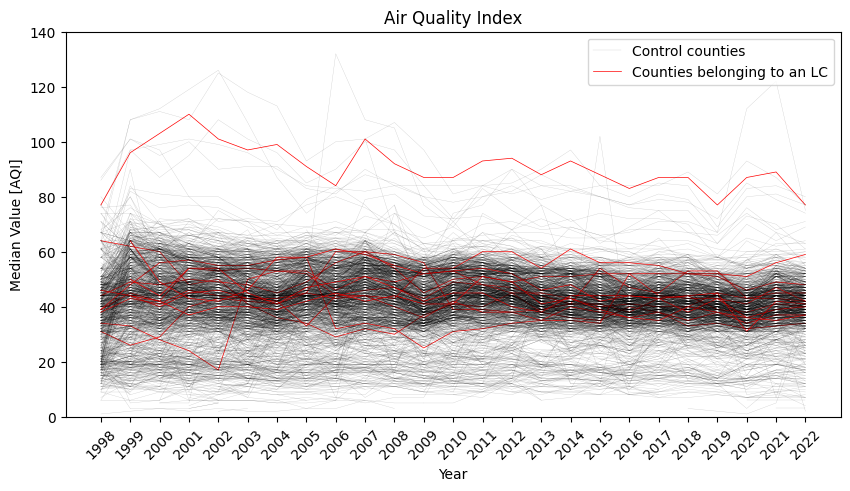

In [ ]:
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in aqi.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = aqi[aqi.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["Median AQI"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["Median AQI"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["Median AQI"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["Median AQI"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value [AQI]")
ax.set_ylim(0,140)
ax.legend()
ax.set_title("Air Quality Index")

fig.show()


Caption: Air Quality Index (AQI) by County. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control.

06065 18063 25027 27003 34003 34007 42071 42077 51107 13151 37179 48135 

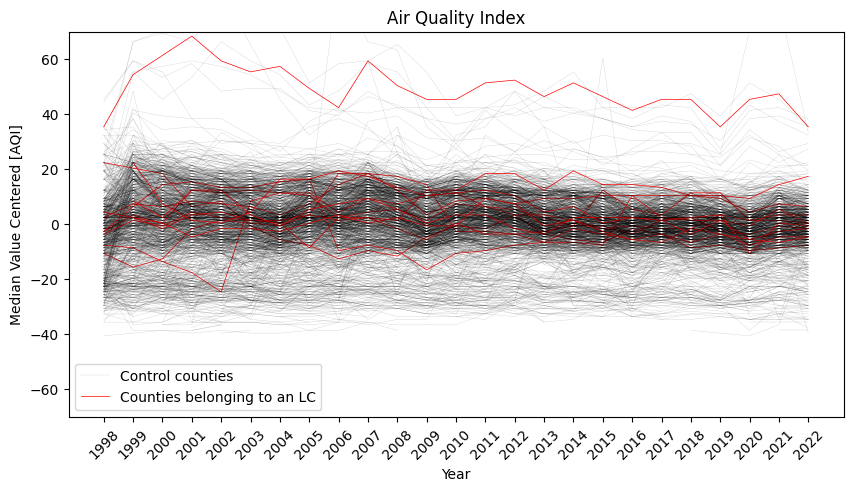

In [ ]:
aqi["AQI_cent"] = aqi['Median AQI'] - aqi["Median AQI"].mean()

# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in aqi.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = aqi[aqi.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["AQI_cent"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["AQI_cent"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["AQI_cent"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["AQI_cent"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value Centered [AQI]")
ax.set_ylim(-70,70)
ax.legend()
ax.set_title("Air Quality Index")

fig.show()

06065 18063 25027 27003 34003 34007 42071 42077 51107 13151 37179 48135 

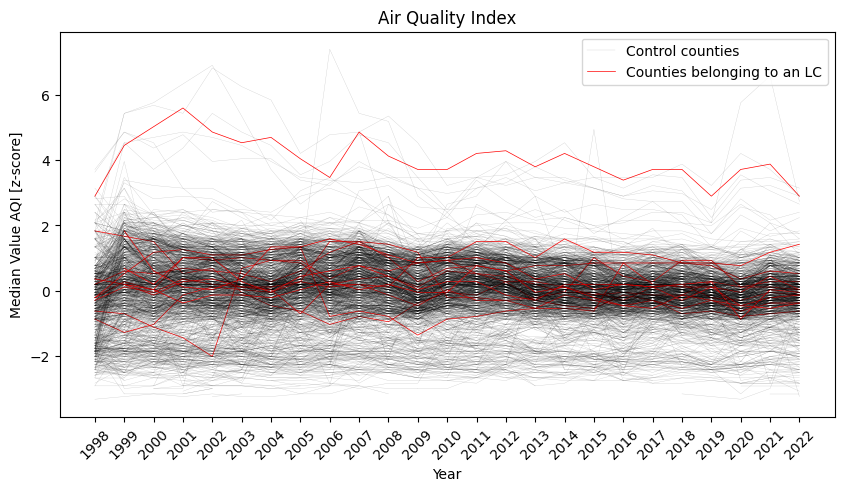

In [ ]:
aqi["z-score"] = (aqi['Median AQI'] - aqi["Median AQI"].mean())/aqi["Median AQI"].std()

# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in aqi.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = aqi[aqi.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["z-score"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["z-score"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["z-score"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["z-score"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value AQI [z-score]")
ax.legend()
ax.set_title("Air Quality Index")

fig.show()

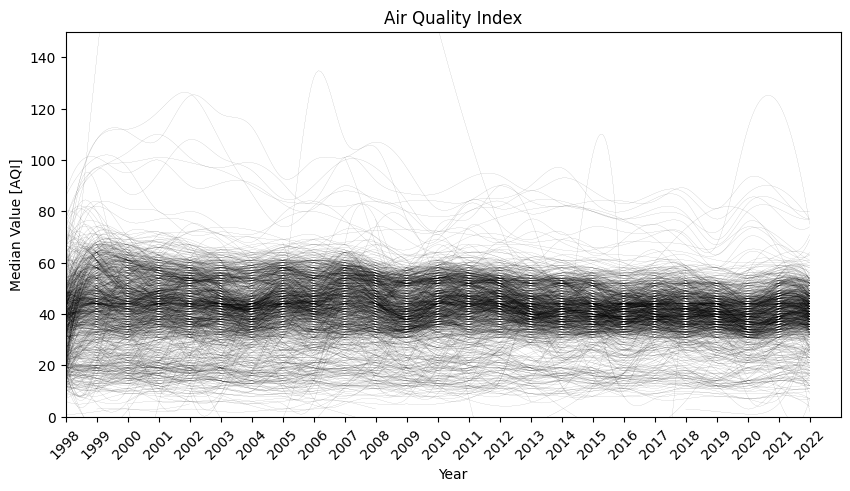

In [ ]:
# Plotting trends
from scipy.interpolate import make_interp_spline, BSpline

fig, ax = plt.subplots(figsize=(10,5))

for i in aqi.GEOID.unique():
  df = aqi[aqi.GEOID == i]
  import numpy as np
  # Sample data
  x = np.array(df.Year)
  y = np.array(df["Median AQI"])

  # Check if enough data points are available for cubic spline interpolation
  if len(x) >= 4:
    # Create a smoother curve using interpolation
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
    y_smooth = spl(x_smooth)

    # Plot the original data and the smooth curve
    ax.plot(x_smooth, y_smooth, linewidth=0.05, color="k")
  else:
    pass

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value [AQI]")
ax.set_ylim(0,150)
ax.set_xlim(1998,2023)
ax.set_title("Air Quality Index")

fig.show()

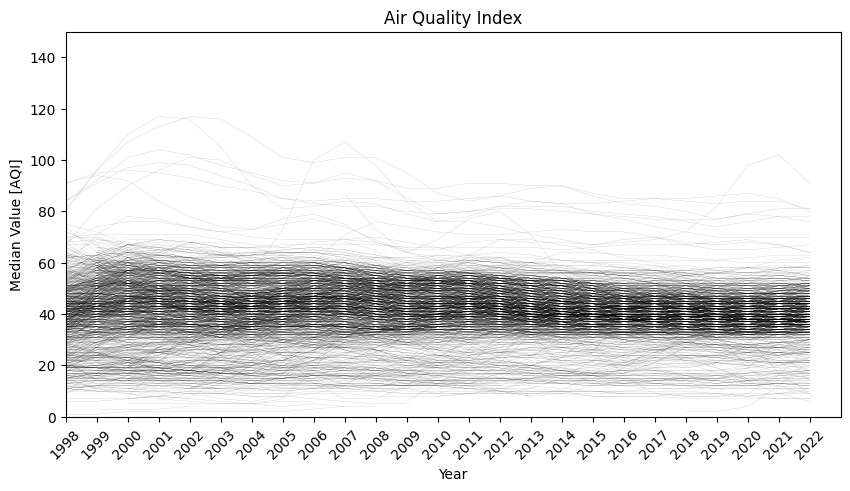

In [ ]:
# Plotting trends
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots(figsize=(10,5))

for i in aqi.GEOID.unique():
  df = aqi[aqi.GEOID == i]
  import numpy as np
  # Sample data
  x = np.array(df.Year)
  y = np.array(df["Median AQI"])

  # Check if enough data points are available for cubic spline interpolation
  if len(x) >= 4:
    # Apply Gaussian smoothing
    y_smooth = gaussian_filter1d(y, sigma=1)  # Adjust sigma for smoothness

    # Plot the original data and the smooth curve
    # Instead of using x_smooth, use the original x values for plotting
    ax.plot(x, y_smooth, linewidth=0.05, color="k")
  else:
    pass

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value [AQI]")
ax.set_ylim(0,150)
ax.set_xlim(1998,2023)
ax.set_title("Air Quality Index")

fig.show()